# Deep Learning Basics

## 1. Linear Regression
https://d2l.ai/chapter_linear-networks/linear-regression.html

### 1.1. Linear regression from scratch in NumPy

In [1]:
import numpy as np
import random

# Define the true weights and bias of the model
w_true = np.array([2, -3.4])
b_true = 4.2

# Generate inputs (standard normal distribution) and derive the outputs (with some noise)
number_examples = 1000
number_features = len(w_true)
X = np.random.default_rng().normal(0, 1, (number_examples, number_features))
y = np.matmul(X, w_true)+b_true+np.random.default_rng().normal(0, 0.01, number_examples)

# Define the parameters for the training
number_epochs = 3
batch_size = 10
lr = 0.03

# Initialize the weights and bias to recover
w = np.random.default_rng().normal(0, 1, number_features)
b = 0

# Initialize a list for the mean loss over the minibatches of every epoch
epoch_loss = np.zeros(number_epochs)

# Loop over the epochs
for i in range(number_epochs):
    
    # Generate the indices for all the examples and shuffle them
    example_indices = np.arange(number_examples)
    random.shuffle(example_indices)
    
    # Initialize a list for the mean loss over the examples of every minibatch
    batch_loss = []
    
    # Loop over the examples in minibatches
    for j in np.arange(0, number_examples, batch_size):
        
        # Get the indices of the examples for one minibatch (randomized) 
        batch_indices = example_indices[j:min(j+batch_size, number_examples)]
        
        # Get the inputs and outputs for the current minibatch
        X_batch = X[batch_indices, :]
        y_batch = y[batch_indices]
        
        # Compute the predicted outputs
        y_hat = np.matmul(X_batch, w) + b
        
        # Compute the loss between the predicted and true outputs
        l = np.mean(0.5*np.power(y_hat-y_batch, 2))
        
        # Save the loss for the current minibatch
        batch_loss.append(l)
        
        # Update the weights and bias using stochastic gradient descent (SGD)
        w = w - lr*np.mean(X_batch*(y_hat-y_batch)[:, np.newaxis], axis=0)
        b = b - lr*np.mean(y_hat-y_batch, axis=0)
        
    # Save the mean loss for the current epoch
    epoch_loss[i] = np.mean(batch_loss)
    
    # Print the progress
    print(f'{i+1}/{number_epochs}: {epoch_loss[i]}')
    
# Print the predicted weights and bias
print('')
print(f'w = {w}')
print(f'b = {b}')

1/3: 3.21178522830051
2/3: 0.006472579643693114
3/3: 6.409211600749226e-05

w = [ 2.00056852 -3.39996605]
b = 4.199792013095364


### 1.2. Linear regression from scratch in PyTorch

In [1]:
import torch
import random

# Define the true weights and bias of the model
w_true = torch.tensor([2, -3.4])
b_true = 4.2

# Generate inputs and derive outputs
number_examples = 1000
number_features = len(w_true)
X = torch.normal(0, 1, (number_examples, number_features))
y = torch.matmul(X, w_true)+b_true+torch.normal(0, 0.01, [number_examples]) # [number_examples]?

# Define a function to read the dataset in random minibatches
def batch(X, y, batch_size):
    
    # Generate the indices for all the examples and shuffle them
    number_examples = X.shape[0]
    example_indices = list(range(number_examples))
    random.shuffle(example_indices)
    
    # Loop over the examples in batches
    for i in range(0, number_examples, batch_size):
        
        # Get the indices of the (randomized) examples for one minibatch
        batch_indices = example_indices[i:min(i+batch_size, number_examples)]
        
        # Return the input and output minibatch and continue the iteration in the function
        yield X[batch_indices], y[batch_indices]

# Define the parameters for the training
number_epochs = 3
batch_size = 10
lr = 0.03

# Initialize the weights and bias to recover, requiring the gradients to be computed
w = torch.normal(0, 1, [number_features], requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Initialize an array for the mean loss over the minibatches of every epoch
epoch_loss = torch.zeros(number_epochs)
        
# Loop over the epochs
for i in range(number_epochs):
    
    # Initialize a list for the mean loss over the examples of every minibatch
    batch_loss = []
    
    # Loop over the examples in minibatches
    for X_batch, y_batch in batch(X, y, batch_size):
        
        # Compute the predicted outputs
        y_hat = torch.matmul(X_batch, w) + b
        
        # Compute the loss between the predicted and true outputs
        l = 0.5*(y_hat-y_batch)**2
        
        # Compute the gradient on l with respect to w and b
        # (sum and not mean as the gradients will be divided by the batch size during SGD)
        l.sum().backward()
        
        # Save the mean loss for the current minibatch
        batch_loss.append(l.mean())
        
        # Temporarily sets all of the requires_grad flags to false
        with torch.no_grad():
            
            # Update the weights and bias using SGD
            # (use augmented assignments to avoid modifying existing variables)
            w -= lr*w.grad/len(l)
            b -= lr*b.grad/len(l)
            
            # Set the gradients to zeros to avoid accumulating gradients
            w.grad.zero_()
            b.grad.zero_()
            
    # Update the mean loss for the current epoch
    epoch_loss[i] = sum(batch_loss)/len(batch_loss)
    
    # Print the progress
    print(f'{i+1}/{number_epochs}: {epoch_loss[i]}')
    
# Print the predicted weights and bias
print('')
print(f'w = {w}')
print(f'b = {b}')

1/3: 2.7032434940338135
2/3: 0.0054627032950520515
3/3: 5.894739297218621e-05

w = tensor([ 1.9999, -3.3993], requires_grad=True)
b = tensor([4.1995], requires_grad=True)


### 1.3. Linear regression using APIs in PyTorch

In [3]:
import torch
from torch.utils import data
from torch import nn

# Define the true weights and bias of the model
w_true = torch.tensor([2, -3.4])
b_true = 4.2

# Generate inputs and derive outputs
number_examples = 1000
number_features = len(w_true)
X = torch.normal(0, 1, (number_examples, number_features))
y = torch.matmul(X, w_true)+b_true+torch.normal(0, 0.01, [number_examples]) # [number_examples]?

# Define a function to read the dataset in random minibatches
def batch(X, y, batch_size):
    
    # Construct a PyTorch data iterator (?)
    data_set = data.TensorDataset(*(X, y))
    return data.DataLoader(data_set, batch_size, shuffle=True)

# Define the parameters for the training
number_epochs = 3
batch_size = 10
lr = 0.03

# Define the model (as a stack of layers) and add a fully-connected layer
model = nn.Sequential(nn.Linear(number_features, 1))

# Initialize the parameters
model[0].weight.data.normal_(0, 0.01)
model[0].bias.data.fill_(0)

# Define the loss function (mean squared error, without the 0.5 factor)
loss = nn.MSELoss()

# Define the optimization algorithm (SGD)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Initialize an array for the mean loss over the minibatches of every epoch
epoch_loss = torch.zeros(number_epochs)

# Loop over the epochs
for i in range(number_epochs):
    
    # Initialize a list for the mean loss over the examples of every minibatch
    batch_loss = []
    
    # Loop over the examples in minibatches
    for X_batch, y_batch in batch(X, y, batch_size):
        
        # Compute the predicted outputs
        y_hat = model(X_batch)
        
        # Compute the loss between the predicted and true outputs
        l = loss(y_hat, y_batch[:, None])
        
        # Save the loss for the current minibatch (no with torch.no_grad()?)
        batch_loss.append(l)
        
        # Set the gradients to zero (.zero_grad()?)
        optimizer.zero_grad()
        
        # Computes the gradient (no .sum?)
        l.backward()
        
        # Performs a single parameter update
        optimizer.step()
        
    # Update the mean loss for the current epoch
    epoch_loss[i] = sum(batch_loss)/len(batch_loss)
        
    # Print the progress
    print(f'{i+1}/{number_epochs}: {epoch_loss[i]}')
    
# Print the predicted weights and bias
print('')
print(f'w = {model[0].weight.data}')
print(f'b = {model[0].bias.data}')

1/3: 2.879786729812622
2/3: 0.0001097871208912693
3/3: 9.997401502914727e-05

w = tensor([[ 2.0003, -3.3999]])
b = tensor([4.2000])


### 1.4. Linear regression using higher-level APIs in Keras

In [4]:
import numpy as np
import tensorflow as tf

# Define the true weights and bias of the model
w_true = np.array([2, -3.4])
b_true = 4.2

# Generate inputs and derive outputs
number_examples = 1000
number_features = len(w_true)
X = np.random.default_rng().normal(0, 1, (number_examples, number_features))
y = np.matmul(X, w_true)+b_true+np.random.default_rng().normal(0, 0.01, number_examples)

# Define the parameters for the training
number_epochs = 3
batch_size = 10
lr = 0.03

# Define the model (as a stack of layers) and add a densely-connected NN layer with initialized parameters
model = tf.keras.Sequential([tf.keras.layers.Dense(1, kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01), \
                                                   bias_initializer='zeros')])

# Configure the model for training with stochastic gradient descent optimizer and mean squared error loss
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
              loss=tf.keras.losses.MeanSquaredError())

# Train the model given the batch size and number of epochs
model.fit(x=X, y=y, batch_size=batch_size, epochs=number_epochs, verbose=1)

# Print the predicted weights and bias
print('')
print(f'w = {model.get_weights()[0]}')
print(f'b = {model.get_weights()[1]}')

Epoch 1/3
100/100 [==============================] - 1s 417us/step - loss: 2.8675
Epoch 2/3
100/100 [==============================] - 0s 354us/step - loss: 1.0620e-04
Epoch 3/3
100/100 [==============================] - 0s 340us/step - loss: 9.6979e-05

w = [[ 1.9992182]
 [-3.4001048]]
b = [4.199602]


## 2. Softmax Regression
https://d2l.ai/chapter_linear-networks/softmax-regression.html

### 2.1. Fashion-MNIST dataset

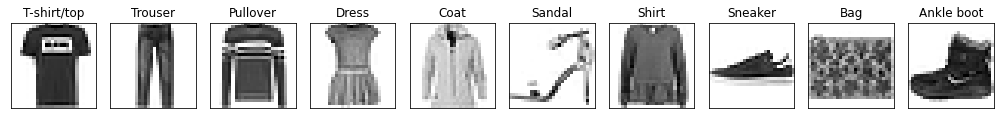

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Get the Fashion-MNIST dataset, with train and test inputs and outputs
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize the inputs
X_train = X_train/255
X_test = X_test/255

# Translate the outputs into labels
label_list = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
label_train = [label_list[i] for i in y_train]
label_test = [label_list[i] for i in y_test]

# Show a single example for the different classes
number_classes = len(label_list)
plt.figure(figsize=(14, 2))
for i in range(number_classes):
    j = np.where(y_train==i)[0][0]
    plt.subplot(1, number_classes, i+1)
    plt.imshow(X_train[j, :, :], cmap='binary')
    plt.title(label_list[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

### 2.2. Softmax regression from scratch in NumPy

1/10: train_loss=0.647; train_accuracy=0.749; test_accuracy=0.786
2/10: train_loss=0.441; train_accuracy=0.813; test_accuracy=0.804
3/10: train_loss=0.398; train_accuracy=0.825; test_accuracy=0.817
4/10: train_loss=0.374; train_accuracy=0.832; test_accuracy=0.822
5/10: train_loss=0.360; train_accuracy=0.837; test_accuracy=0.823
6/10: train_loss=0.349; train_accuracy=0.840; test_accuracy=0.827
7/10: train_loss=0.341; train_accuracy=0.843; test_accuracy=0.812
8/10: train_loss=0.334; train_accuracy=0.845; test_accuracy=0.820
9/10: train_loss=0.329; train_accuracy=0.847; test_accuracy=0.828
10/10: train_loss=0.324; train_accuracy=0.849; test_accuracy=0.831


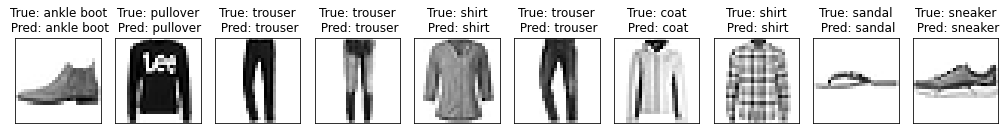

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

# Get the train and test inputs and outputs
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
number_train = len(X_train)
number_test = len(X_test)

# Normalize and flatten the inputs
input_size = np.size(X_train[0])
X_train = np.reshape(X_train/255, (number_train, input_size))
X_test = np.reshape(X_test/255, (number_test, input_size))

# Derive one-hot versions of the train outputs
output_size = 10
y_train1 = np.zeros((number_train, output_size))
for i in range(number_train):
    y_train1[i, y_train[i]] = 1

# Define the parameters for the training
number_epochs = 10
batch_size = 256
lr = 0.1

# Initialize the weights and bias to recover
W = np.random.default_rng().normal(0, 0.01, size=(input_size, output_size)) # 0.01?
b = np.zeros(output_size)

# Initialize lists for the mean train loss and accuracy over the minibatches for every epoch
train_loss = [[] for _ in range(number_epochs)]
train_accuracy = [[] for _ in range(number_epochs)]

# Initialize a list for the test accuracy overall for every epoch
test_accuracy = [None]*number_epochs

# Loop over the epochs
for i in range(number_epochs):
    
    # Generate random indices for all the train examples
    train_indices = np.arange(number_train)
    random.shuffle(train_indices)
    
    # Loop over the train examples in minibatches
    for j in np.arange(0, number_train, batch_size):
        
        # Get the indices of the train examples for one minibatch
        batch_indices = train_indices[j:min(j+batch_size, number_train)]
        
        # Get the train inputs and outputs for the minibatch
        X = X_train[batch_indices, :]
        y = y_train[batch_indices]
        y1 = y_train1[batch_indices]
        
        # Compute the predicted outputs (logits)
        o = np.matmul(X, W) + b
        
        # Compute the softmax of the logits (indirectly to avoid numerical stability issues)
        o = o-np.max(o, axis=1)[:, np.newaxis]
        o_exp = np.exp(o)
        y_hat = o_exp/np.sum(o_exp, axis=1)[:, np.newaxis]
        
        # Compute the mean cross-entropy loss for the minibatch
        l = np.mean(np.log(np.sum(o_exp, axis=1)-np.sum(y1*o, axis=1)))
        train_loss[i].append(l)
        
        # Compute the mean accuracy for the minibatch
        a = np.mean(np.argmax(y_hat, axis=1)==y)
        train_accuracy[i].append(a)
        
        # Update the weights and bias using SGD
        dl = y_hat-y1
        W = W-lr*np.matmul(X.T, dl)/np.shape(X)[0]
        b = b-lr*np.mean(dl, axis=0)
        
    # Derive the mean train loss and accuracy for the current epoch
    train_loss[i] = np.mean(train_loss[i])
    train_accuracy[i] = np.mean(train_accuracy[i])
    
    # Compute the test outputs and derive the test accuracy for the current epoch
    o = np.matmul(X_test, W) + b
    o = o-np.max(o, axis=1)[:, np.newaxis]
    o_exp = np.exp(o)
    y_hat = o_exp/np.sum(o_exp, axis=1)[:, np.newaxis]
    test_accuracy[i] = np.mean(np.argmax(y_hat, axis=1)==y_test)
    
    # Print the progress
    print(f'{i+1}/{number_epochs}: train_loss={train_loss[i]:.3f}; train_accuracy={train_accuracy[i]:.3f}; test_accuracy={test_accuracy[i]:.3f}')
    
# Show some predictions
plt.figure(figsize=(14, 2))
number_examples = 10
label_list = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
for i in range(number_examples):
    for X, y in test_iter:
        break
    o = np.matmul(X_test, W) + b
    o_exp = np.exp(o)
    o = o-np.max(o, axis=1)[:, np.newaxis]
    y_hat = o_exp/np.sum(o_exp, axis=1)[:, np.newaxis]
    y_hat = np.argmax(y_hat, axis=1)
    plt.subplot(1, number_examples, i+1)
    plt.imshow(X[i][0], cmap='binary')
    plt.title(f'True: {label_list[y[i].item()]}\n Pred: {label_list[y_hat[i]]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

### 2.3. Softmax regression from scratch in PyTorch

1/10: train_loss=0.785; train_accuracy=0.750; test_accuracy=0.793
2/10: train_loss=0.570; train_accuracy=0.814; test_accuracy=0.800
3/10: train_loss=0.525; train_accuracy=0.826; test_accuracy=0.819
4/10: train_loss=0.501; train_accuracy=0.833; test_accuracy=0.823
5/10: train_loss=0.486; train_accuracy=0.837; test_accuracy=0.823
6/10: train_loss=0.473; train_accuracy=0.841; test_accuracy=0.822
7/10: train_loss=0.464; train_accuracy=0.843; test_accuracy=0.831
8/10: train_loss=0.458; train_accuracy=0.845; test_accuracy=0.829
9/10: train_loss=0.452; train_accuracy=0.847; test_accuracy=0.833
10/10: train_loss=0.447; train_accuracy=0.849; test_accuracy=0.832


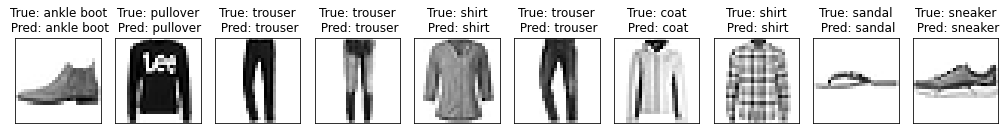

In [10]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils import data

# Get the dataset (convert the image data from PIL type to 32-bit floating point tensors in [0, 1])
fmnist_train = torchvision.datasets.FashionMNIST(root="data", train=True, download=True, 
                                                 transform=torchvision.transforms.ToTensor())
fmnist_test = torchvision.datasets.FashionMNIST(root="data", train=False, download=True,
                                                transform=torchvision.transforms.ToTensor())

# Define the parameters for the training
number_epochs = 10
batch_size = 256
lr = 0.1

# Use data iterators to read a minibatch at each iteration, shuffling the examples for the train and using 4 processes
train_iter = data.DataLoader(fmnist_train, batch_size, shuffle=True, num_workers=4)
test_iter = data.DataLoader(fmnist_test, batch_size, shuffle=False, num_workers=4)

# Initialize the parameters to recover, requiring the gradients to be computed
input_size = fmnist_train[0][0].nelement()
output_size = 10
W = torch.normal(0, 0.01, size=(input_size, output_size), requires_grad=True)
b = torch.zeros(output_size, requires_grad=True)

# Initialize lists for the mean train loss, train and test accuracy over the minibatches for every epoch
train_loss = [[] for _ in range(number_epochs)]
train_accuracy = [[] for _ in range(number_epochs)]
test_accuracy = [[] for _ in range(number_epochs)]

# Loop over the epochs
for i in range(number_epochs):
    
    # Loop over the train examples in minibatches
    for X, y in train_iter:
        
        # Compute the logits, after flattening the images
        O = torch.matmul(torch.reshape(X, (-1, input_size)), W) + b

        # Compute the softmax of the logits
        O_exp = torch.exp(O)
        y_hat = O_exp/torch.sum(O_exp, 1, keepdim=True)
        
        # Compute the cross-entropy loss (use the indices of the true classes in y_batch 
        # to get the corresponding probabilities in y_batch, for all the examples)
        l = -torch.log(y_hat[range(y_hat.shape[0]), y])
        
        # Save the mean loss for the minibatch
        train_loss[i].append(torch.mean(l).item())
        
        # Compute the mean accuracy for the minibatch and save it
        a = torch.mean((torch.argmax(y_hat, dim=1)==y)*1.0).item()
        train_accuracy[i].append(a)
        
        # Compute the gradient on l with respect to W and b
        # (sum and not mean as the gradients will be divided by the batch size during SGD)
        torch.sum(l).backward()
        
        # Disable gradient calculation for the following operations not to be differentiable
        with torch.no_grad():
            
            # Update the weights and bias using SGD
            # (use augmented assignments to avoid modifying existing variables)
            W -= lr*W.grad/len(l)
            b -= lr*b.grad/len(l)
            
            # Set the gradients to zeros to avoid accumulating gradients
            W.grad.zero_()
            b.grad.zero_()
    
    # Derive the mean train loss and accuracy for the current epoch
    train_loss[i] = sum(train_loss[i])/len(train_loss[i])
    train_accuracy[i] = sum(train_accuracy[i])/len(train_accuracy[i])
    
    # Compute the test outputs and derive the test accuracy for every epoch, in minibatches
    with torch.no_grad():
        for X, y in test_iter:
            O = torch.matmul(torch.reshape(X, (-1, input_size)), W) + b
            O_exp = torch.exp(O)
            y_hat = O_exp/torch.sum(O_exp, 1, keepdim=True)
            a = torch.mean((torch.argmax(y_hat, dim=1)==y)*1.0).item()
            test_accuracy[i].append(a)
    test_accuracy[i] = sum(test_accuracy[i])/len(test_accuracy[i])
    
    # Print the progress
    print(f'{i+1}/{number_epochs}: train_loss={train_loss[i]:.3f}; train_accuracy={train_accuracy[i]:.3f}; test_accuracy={test_accuracy[i]:.3f}')
    
# Show some predictions
plt.figure(figsize=(14, 2))
number_examples = 10
label_list = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
for i in range(number_examples):
    for X, y in test_iter:
        break
    O = torch.matmul(torch.reshape(X, (-1, input_size)), W) + b
    O_exp = torch.exp(O)
    y_hat = O_exp/torch.sum(O_exp, 1, keepdim=True)
    y_hat = torch.argmax(y_hat, dim=1)
    plt.subplot(1, number_examples, i+1)
    plt.imshow(X[i][0], cmap='binary')
    plt.title(f'True: {label_list[y[i].item()]}\n Pred: {label_list[y_hat[i]]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

### 2.4. Softmax regression using APIs in PyTorch

1/10: train_loss=0.786; train_accuracy=0.749; test_accuracy=0.794
2/10: train_loss=0.572; train_accuracy=0.813; test_accuracy=0.811
3/10: train_loss=0.525; train_accuracy=0.826; test_accuracy=0.815
4/10: train_loss=0.502; train_accuracy=0.832; test_accuracy=0.825
5/10: train_loss=0.485; train_accuracy=0.836; test_accuracy=0.819
6/10: train_loss=0.475; train_accuracy=0.840; test_accuracy=0.829
7/10: train_loss=0.466; train_accuracy=0.843; test_accuracy=0.829
8/10: train_loss=0.458; train_accuracy=0.845; test_accuracy=0.831
9/10: train_loss=0.452; train_accuracy=0.847; test_accuracy=0.826
10/10: train_loss=0.448; train_accuracy=0.848; test_accuracy=0.832


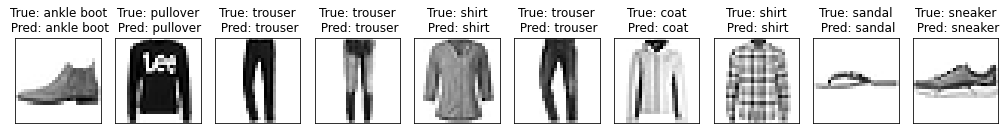

In [15]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torch.utils import data

# Get the dataset (convert the image data from PIL type to 32-bit floating point tensors in [0, 1])
fmnist_train = torchvision.datasets.FashionMNIST(root="data", train=True, download=True, 
                                                 transform=torchvision.transforms.ToTensor())
fmnist_test = torchvision.datasets.FashionMNIST(root="data", train=False, download=True,
                                                transform=torchvision.transforms.ToTensor())

# Define the parameters for the training
number_epochs = 10
batch_size = 256
lr = 0.1

# Use data iterators to read a minibatch at each iteration, shuffling the examples for the train and using 4 processes
train_iter = data.DataLoader(fmnist_train, batch_size, shuffle=True, num_workers=4)
test_iter = data.DataLoader(fmnist_test, batch_size, shuffle=False, num_workers=4)

# Define the model, with a flatten layer to reshape the inputs before the fully-connected layer
input_size = fmnist_train[0][0].nelement()
output_size = 10
model = nn.Sequential(nn.Flatten(), nn.Linear(input_size, output_size))

# Initialize the parameters by applying a function recursively to every submodule
def init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std=0.01)
model.apply(init);

# Define the loss function (with no reduction applied to the output, no mean, no sum, none)
loss = nn.CrossEntropyLoss(reduction='none')

# Define the optimization algorithm
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Initialize lists for the mean train loss, train and test accuracy over the minibatches for every epoch
train_loss = [[] for _ in range(number_epochs)]
train_accuracy = [[] for _ in range(number_epochs)]
test_accuracy = [[] for _ in range(number_epochs)]

# Loop over the epochs
for i in range(number_epochs):
    
    # Loop over the train examples in minibatches
    for X, y in train_iter:
        
        # Compute the predicted outputs
        y_hat = model(X)
        
        # Compute the loss between the predicted and true outputs
        l = loss(y_hat, y)
        
        # Save the mean loss for the minibatch
        train_loss[i].append(torch.mean(l).item())
        
        # Compute the mean accuracy for the minibatch and save it
        a = torch.mean((torch.argmax(y_hat, dim=1)==y)*1.0).item()
        train_accuracy[i].append(a)
        
        # Set the gradients to zero
        optimizer.zero_grad()
        
        # Computes the gradient
        l.mean().backward()
        
        # Performs a single parameter update
        optimizer.step()
        
    # Derive the mean train loss and accuracy for the current epoch
    train_loss[i] = sum(train_loss[i])/len(train_loss[i])
    train_accuracy[i] = sum(train_accuracy[i])/len(train_accuracy[i])
    
    # Compute the test outputs and derive the test accuracy for every epoch, in minibatches
    with torch.no_grad():
        for X, y in test_iter:
            y_hat = model(X)
            a = torch.mean((torch.argmax(y_hat, dim=1)==y)*1.0).item()
            test_accuracy[i].append(a)
    test_accuracy[i] = sum(test_accuracy[i])/len(test_accuracy[i])
    
    # Print the progress
    print(f'{i+1}/{number_epochs}: train_loss={train_loss[i]:.3f}; train_accuracy={train_accuracy[i]:.3f}; test_accuracy={test_accuracy[i]:.3f}')
    
# Show some predictions
plt.figure(figsize=(14, 2))
number_examples = 10
label_list = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
for i in range(number_examples):
    for X, y in test_iter:
        break
    y_hat = model(X)
    y_hat = torch.argmax(y_hat, dim=1)
    plt.subplot(1, number_examples, i+1)
    plt.imshow(X[i][0], cmap='binary')
    plt.title(f'True: {label_list[y[i].item()]}\n Pred: {label_list[y_hat[i]]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()